In [18]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import pandas as pd
from scipy.special import digamma, gamma, logsumexp, expit
from scipy.stats import norm, gamma, bernoulli
import torch
import torch.distributions as dist
from torch import nn
# from torchvision import datasets, transforms
import torch.nn.functional as F
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm

In [2]:
%config InlineBackend.figure_format = 'retina'

# Plannar flows

In [3]:
class Planar(nn.Module):
    def __init__(self, size=1, init_sigma=0.01):
        super().__init__()
        self.u = nn.Parameter(torch.randn(1, size).normal_(0, init_sigma))
        self.w = nn.Parameter(torch.randn(1, size).normal_(0, init_sigma))
        self.b = nn.Parameter(torch.zeros(1))

    @property
    def normalized_u(self):
        """
        Needed for invertibility condition.

        See Appendix A.1
        Rezende et al. Variational Inference with Normalizing Flows
        https://arxiv.org/pdf/1505.05770.pdf
        """

        # softplus
        def m(x):
            return -1 + torch.log(1 + torch.exp(x))

        wtu = torch.matmul(self.w, self.u.t())
        w_div_w2 = self.w / torch.norm(self.w)
        return self.u + (m(wtu) - wtu) * w_div_w2

    def psi(self, z):
        """
        ψ(z) =h′(w^tz+b)w

        See eq(11)
        Rezende et al. Variational Inference with Normalizing Flows
        https://arxiv.org/pdf/1505.05770.pdf
        """
        return self.h_prime(z @ self.w.t() + self.b) @ self.w

    def h(self, x):
        return torch.tanh(x)

    def h_prime(self, z):
        return 1 - torch.tanh(z) ** 2

    def forward(self, z):
        if isinstance(z, tuple):
            z, accumulating_ldj = z
        else:
            z, accumulating_ldj = z, 0
        psi = self.psi(z)

        u = self.normalized_u

        # determinant of jacobian
        det = (1 + psi @ u.t())

        # log |det Jac|
        ldj = torch.log(torch.abs(det) + 1e-6)

        wzb = z @ self.w.t() + self.b

        fz = z + (u * self.h(wzb))

        return fz, ldj + accumulating_ldj

In [4]:
class Flow(nn.Module):
    def __init__(self, dim=2, n_flows=10):
        super().__init__()
        self.flow = nn.Sequential(*[
            Planar(dim) for _ in range(n_flows)
        ])
        self.mu = nn.Parameter(torch.randn(dim, ).normal_(0, 0.01))
        self.log_var = nn.Parameter(torch.randn(dim, ).normal_(1, 0.01))

    def forward(self, shape):
        std = torch.exp(0.5 * self.log_var)
        eps = torch.randn(shape)  # unit gaussian
        z0 = self.mu + eps * std

        zk, ldj = self.flow(z0)
        return z0, zk, ldj, self.mu, self.log_var

# Hierarchical model - only user

In [5]:
np.random.seed(123)

sg = 0.5
mu = -4

n_u = 20
n_obs_per_u = 100
n_obs = n_obs_per_u*n_u

u = np.concatenate([np.zeros(n_obs_per_u, dtype=int) + i for i in range(n_u)])
theta_u = np.random.normal(mu, sg, size=n_u)   

x = np.random.uniform(0.1, 100, size=n_obs)
rd = np.random.random(size=n_obs)

y = np.zeros(shape=n_obs, dtype=float)

theta = theta_u[u]

rate = np.exp(theta)
exponent = - rate * x
p = np.exp(exponent)
y[:] = p > rd

In [6]:
print("mean alpha", np.mean(theta))
print("mean std", np.std(theta))

mean alpha -3.9427911340223547
mean std 0.6128066343702181


## Optimizing each user separately

In [7]:
def det_loss(x, y, mu, log_var, z_0, z_k, ldj):
    # Note that I assume uniform prior here.
    # So P(z) is constant and not modelled in this loss function
    # batch_size = z_0.size(0)

    # Qz0
    log_qz0 = dist.Normal(mu, torch.exp(0.5 * log_var)).log_prob(z_0)
    # Qzk = Qz0 + sum(log det jac)
    log_qzk = log_qz0.sum() - ldj.sum()
    
    # P(x|z)
    log_p = -torch.exp(z_k[:, 0])*x
    nll = - dist.Bernoulli(probs=torch.exp(log_p)).log_prob(y).sum()
    
    return log_qzk + nll 

In [8]:
def train_flow(x, y, flow, shape, epochs=1000, verbose=False):
    optim = torch.optim.Adam(flow.parameters(), lr=1e-2)

    for i in range(epochs):
        z0, zk, ldj, mu, log_var = flow(shape=shape)
        loss = det_loss(x=x,
                        y=y,
                        mu=mu,
                        log_var=log_var,
                        z_0=z0,
                        z_k=zk,
                        ldj=ldj)
        loss.backward()
        optim.step()
        optim.zero_grad()
        if i % 250 == 0 and verbose:
            print(loss.item())


In [9]:
alpha_u = np.zeros(n_u)
for i in tqdm(range(n_u)):
    y_u = y[u==i]
    x_u = x[u==i]
    flow = Flow(dim=1, n_flows=6)
    shape = (1, 1)
    train_flow(x=torch.from_numpy(x_u), y=torch.from_numpy(y_u), flow=flow, shape=shape, epochs=1000)
    z0, zk, ldj, mu, log_var = flow((5000, 1))
    alpha_samples = np.array(zk.data[:, 0])
    alpha_u[i] = np.mean(alpha_samples)

100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


In [10]:
print(np.mean(alpha_u))
print(np.std(alpha_u))

-3.968748593330383
0.5804048818326202


## Optimizing over all users

In [11]:
def det_loss(x, y, mu, log_var, z_0, z_k, ldj):
    # Note that I assume uniform prior here.
    # So P(z) is constant and not modelled in this loss function
    # batch_size = z_0.size(0)

    # Qz0
    log_qz0 = dist.Normal(mu, torch.exp(0.5 * log_var)).log_prob(z_0)
    # Qzk = Qz0 + sum(log det jac)
    log_qzk = log_qz0.sum() - ldj.sum()
    
    # P(x|z)
    ll = torch.zeros(n_u)
    for i in range(n_u):
        a = z_k[i, 0]
        y_u = y[u==i]
        x_u = x[u==i]
        log_p = -torch.exp(a)*x_u
        ll[i] = dist.Bernoulli(probs=torch.exp(log_p)).log_prob(y_u).sum()

    nll = - ll.sum()
    
    return log_qzk + nll 

In [22]:
def train_flow(x, y, flow, shape, epochs=1000):
    optim = torch.optim.Adam(flow.parameters(), lr=1e-2)
    
    with tqdm(total=epochs) as pbar:
        for i in range(epochs):
            z0, zk, ldj, mu, log_var = flow(shape=shape)
            loss = det_loss(x=x,
                            y=y,
                            mu=mu,
                            log_var=log_var,
                            z_0=z0,
                            z_k=zk,
                            ldj=ldj)
            loss.backward()
            optim.step()
            optim.zero_grad()
            if i % 100 == 0 and verbose:
                pbar.set_postfix({'loss': loss.item()})
            pbar.update()


In [23]:
flow = Flow(dim=1, n_flows=16)
shape = (n_u, 1)
train_flow(x=torch.from_numpy(x), y=torch.from_numpy(y), flow=flow, shape=shape, epochs=5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [24]:
z0, zk, ldj, mu, log_var = flow((5000, 1))
alpha_samples = np.array(zk.data[:, 0])
print(np.mean(alpha_samples))
print(np.std(alpha_samples))

-3.9760933
0.16366829


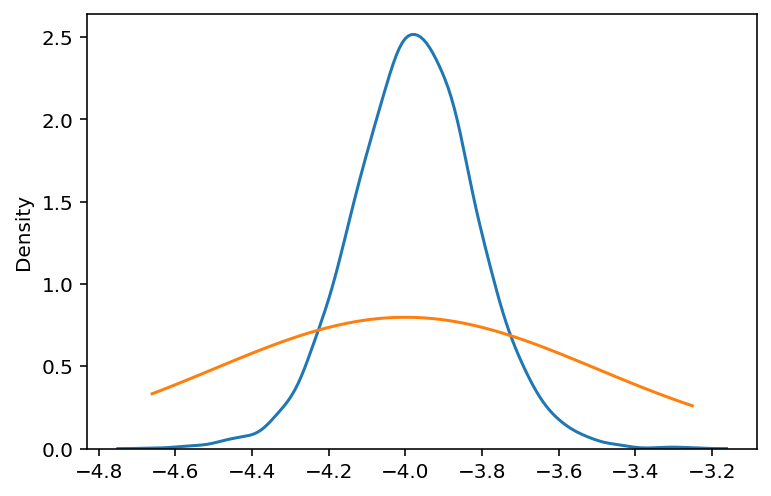

In [25]:
fig, ax = plt.subplots() 
sns.kdeplot(alpha_samples, ax=ax)
x_plot = np.linspace(np.min(alpha_samples), np.max(alpha_samples), 100)
ax.plot(x_plot, stats.norm(loc=-4, scale=0.5).pdf(x_plot))

# Alternative

In [26]:
def det_loss(x, y, mu, log_var, z_0, z_k, ldj):
    # Note that I assume uniform prior here.
    # So P(z) is constant and not modelled in this loss function
    # batch_size = z_0.size(0)

    # Qz0
    log_qz0 = dist.Normal(mu, torch.exp(0.5 * log_var)).log_prob(z_0)
    # Qzk = Qz0 + sum(log det jac)
    log_qzk = log_qz0.sum() - ldj.sum()
    
    mu_alpha = z_k[0, 0]
    sigma_alpha = torch.exp(0.5*z_k[0, 1]) 
    eps = torch.randn(n_u)
    a = mu_alpha + eps * sigma_alpha
    
    # P(x|z)
    ll = torch.zeros(n_u)
    for i in range(n_u):
        a_i = a[i]
        y_u = y[u==i]
        x_u = x[u==i]
        log_p = -torch.exp(a_i)*x_u
        ll[i] = dist.Bernoulli(probs=torch.exp(log_p)).log_prob(y_u).sum()

    nll = - ll.sum()
    
    return log_qzk + nll 

In [27]:
def train_flow(x, y, flow, shape, epochs=1000):
    optim = torch.optim.Adam(flow.parameters(), lr=1e-2)
    
    with tqdm(total=epochs) as pbar:
        for i in range(epochs):
            z0, zk, ldj, mu, log_var = flow(shape=shape)
            loss = det_loss(x=x,
                            y=y,
                            mu=mu,
                            log_var=log_var,
                            z_0=z0,
                            z_k=zk,
                            ldj=ldj)
            loss.backward()
            optim.step()
            optim.zero_grad()
            if i % 100 == 0:
                pbar.set_postfix({'loss': loss.item()})
            pbar.update()


In [29]:
n_dim = 2
flow = Flow(dim=n_dim, n_flows=16)
shape = (1, n_dim)
train_flow(x=torch.from_numpy(x), y=torch.from_numpy(y), flow=flow, shape=shape, epochs=5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [30]:
z0, zk, ldj, mu, log_var = flow((5000, n_dim))

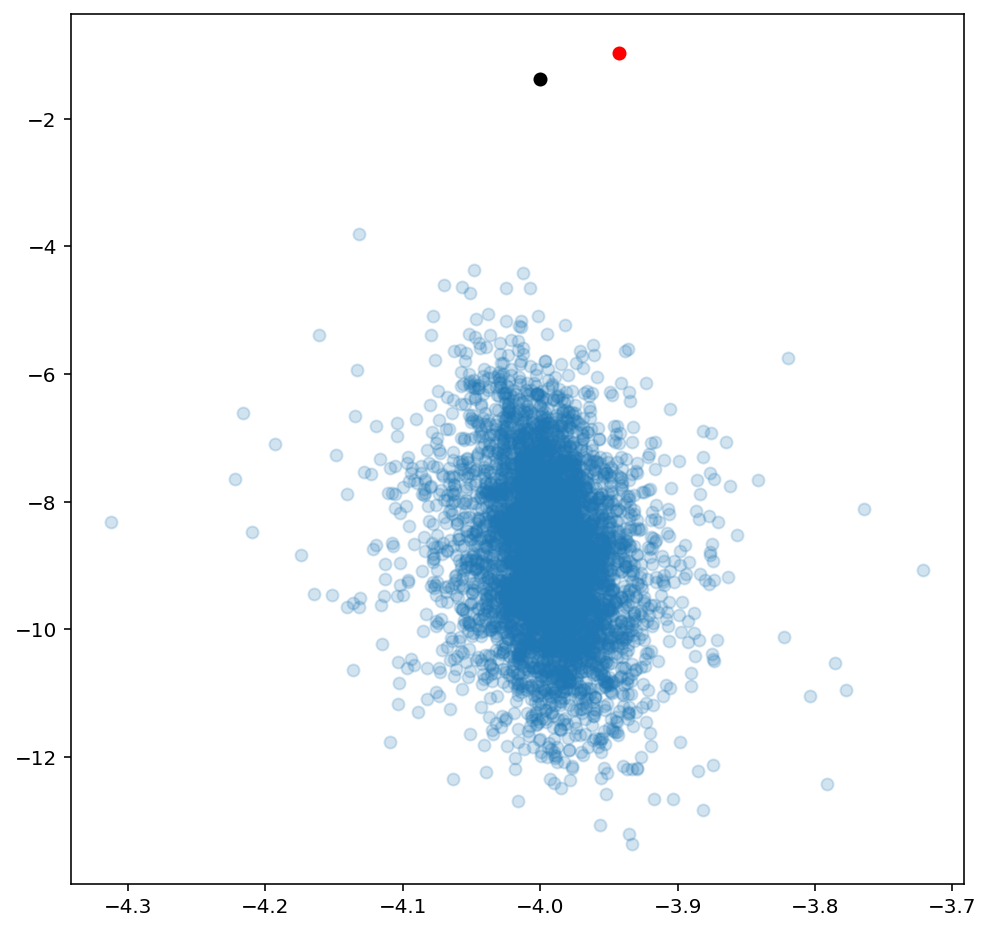

In [31]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(zk.data[:, 0], zk.data[:, 1], color='C0', alpha=0.2)

# Plot truth
ax.scatter(-4, np.log(0.5**2), color='black', alpha=1)
ax.scatter(np.mean(theta), np.log(np.std(theta)**2), color='red', alpha=1)

# Old stuff

In [140]:
%%time
old_mu = 0
old_std = 1
itr = 1
old_lls = -np.inf

def optimize_alpha(x, y, mu, std):

    def opt(param):
        ll = 0
        for i, u_i in enumerate(range(n_u)):
            a = param[i]
            y_u = y[u==u_i]
            x_u = x[u==u_i]
            p = np.exp(-np.exp(a)*x_u)
            ll += np.log(p**y_u*(1-p)**(1-y_u)+eps).sum()
        return - ll - norm.logpdf(param, loc=mu, scale=std).sum() 

    res = scipy.optimize.minimize(opt, x0=np.zeros(n_u))
    return -res.fun, res.x

while True:
    lls, alpha_u = optimize_alpha(x=x, y=y, mu=old_mu, std=old_std)
    mu = np.mean(alpha_u)
    std = np.std(alpha_u)
    print(itr, mu, std, old_mu, old_std)
    if np.allclose([mu, std, lls], [old_mu, old_std, old_lls]):
        break
    old_mu = mu
    old_std = std
    old_lls = lls
    itr += 1

1 -3.8733522924283363 0.5355188827648039 0 1
2 -3.951524210175363 0.5130143769129993 -3.8733522924283363 0.5355188827648039
3 -3.956906089757959 0.5097234317274629 -3.951524210175363 0.5130143769129993
4 -3.9572712275845134 0.5091429478652355 -3.956906089757959 0.5097234317274629
5 -3.957288186699155 0.5090329276481691 -3.9572712275845134 0.5091429478652355
6 -3.9572869805651827 0.5090113655637353 -3.957288186699155 0.5090329276481691
7 -3.957286465334609 0.509007121018971 -3.9572869805651827 0.5090113655637353
CPU times: user 4.83 s, sys: 27.8 ms, total: 4.86 s
Wall time: 4.87 s


## Hierarchical modeling - both user and item

In [420]:
np.random.seed(1234)

sg_u = 0.5
sg_w = 1.0
mu = -4

n_u = 20
n_w = 20
n_obs_per_wu = 50
n_obs = n_obs_per_wu*n_u*n_w

u = np.concatenate([np.zeros(n_obs_per_wu*n_w, dtype=int) + i for i in range(n_u)])
w = np.tile(np.concatenate([np.zeros(n_obs_per_wu, dtype=int) + i for i in range(n_w)]), n_u)

Zu = np.random.normal(0, sg_u, size=n_u) 
Zw = np.random.normal(0, sg_w, size=n_w) 

x = np.random.uniform(0.1, 100, size=n_obs)
rd = np.random.random(size=n_obs)

y = np.zeros(shape=n_obs, dtype=int)

Z = mu + Zu[u] + Zw[w]

rate = np.exp(Z)
p = np.exp(-rate*x)
y[:] = p > rd

(array([12107.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  7893.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

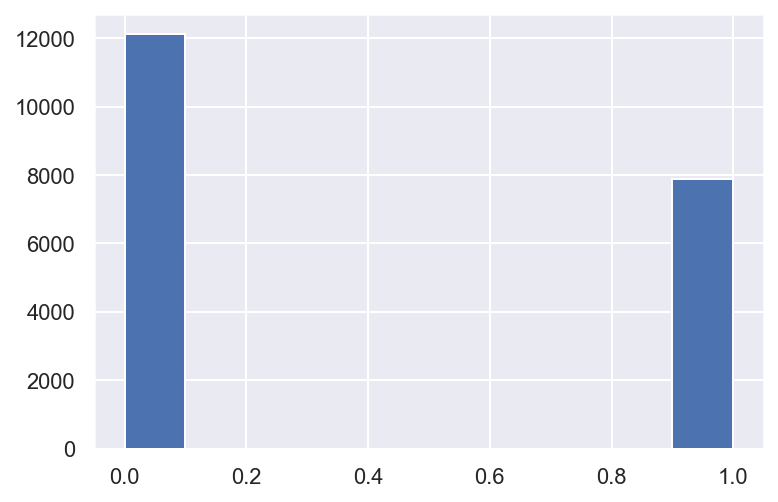

In [421]:
plt.hist(y)

In [422]:
n_obs

20000

In [423]:
print(np.std(Zu))

0.5369771468717787


In [424]:
print(np.std(Zw))

0.8798483035728747


In [425]:
print(np.mean(Z))

-3.6916100349066414


In [426]:
np.mean(mu + Zu + Zw)

-3.6916100349066427

In [427]:
%%time
eps = np.finfo(float).eps

old_sg_u = 1.
old_sg_w = 1.
old_mu = 0.

itr = 1

def optimize_Zu_Zw(x, y, sg_w, sg_u, mu):
    
    def opt(param):
        
        Zu = param[:n_u]
        Zw = param[n_u:]
        
        Z = Zu[u] + Zw[w]
        
        a = np.exp(Z) 
        neg_rate = -a*x                                               # p = np.exp(-rate*x)
        ll_y = np.sum(neg_rate*y+(1-y)*np.log(1 - np.exp(neg_rate)))  # np.log(p**y*(1-p)**(1-y)+eps).sum()
        
        ll_zw = norm.logpdf(Zw, loc=mu/2, scale=sg_w).sum()
        ll_zu =  norm.logpdf(Zu, loc=mu/2, scale=sg_u).sum() 
        
        return - ll_y - ll_zw - ll_zu

    res = scipy.optimize.minimize(opt, 
                                  x0=np.zeros(n_u+n_w))
    
    return res.x[:n_u], res.x[n_u:]


while True:
    
    Zu, Zw = optimize_Zu_Zw(x=x, y=y, sg_w=old_sg_w, sg_u=old_sg_u, mu=old_mu)
    
    mu = 2*np.mean(np.concatenate((Zu,Zw))
    sg_u = np.std(Zu)
    sg_w = np.std(Zw)
                                  
    print(itr, mu, sg_u, sg_w)
    if np.allclose([mu, sg_u, sg_w], [old_mu, old_sg_u, old_sg_w]):
        print("Converged!")
        break
    old_mu = mu
    old_sg_u = sg_u
    old_sg_w = sg_w
    itr += 1

1 -3.6845133844184614 0.5619708653389855 0.8644448857714176
2 -3.6897942654925995 0.5581899894107235 0.8617139764048004
3 -3.689807533827504 0.5581110421811798 0.8616579550998932
4 -3.689807541691762 0.5581093558410232 0.8616568124460684
Converged!
CPU times: user 33 s, sys: 430 ms, total: 33.4 s
Wall time: 34.7 s


## Two parameters model

In [440]:
# Seed
np.random.seed(0)

sg_u = 0.5, 0.2
sg_w = 1.0, 0.4
mu = -4., -2.

n_u = 20
n_w = 20
n_obs_per_wu = 50
n_obs = n_obs_per_wu*n_u*n_w

u = np.concatenate([np.zeros(n_obs_per_wu*n_w, dtype=int) + i for i in range(n_u)])
w = np.tile(np.concatenate([np.zeros(n_obs_per_wu, dtype=int) + i for i in range(n_w)]), n_u)
r = np.tile(np.concatenate([np.arange(n_obs_per_wu, dtype=int) for _ in range(n_w)]), n_u)

Zu = np.random.normal(np.zeros(2), sg_u, size=(n_u, 2)) 
Zw = np.random.normal(np.zeros(2), sg_w, size=(n_w, 2)) 

x = np.random.uniform(50, 1000, size=n_obs)
rd = np.random.random(size=n_obs)

y = np.zeros(shape=n_obs, dtype=int)

Z = mu + Zu[u] + Zw[w]

a = np.exp(Z[:, 0])
b = expit(Z[:, 1])
neg_rate = - a * x * (1-b)**r
p = np.exp(neg_rate)
y[:] = p > rd

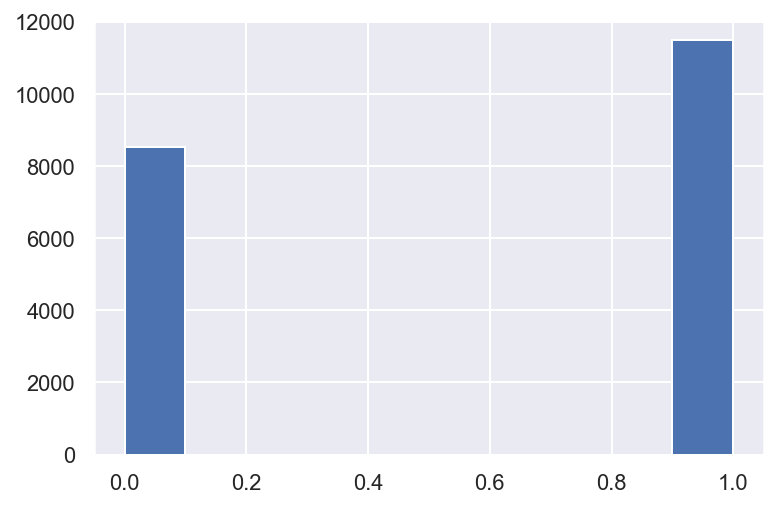

In [441]:
plt.hist(y);

In [442]:
b_smp = np.random.normal(loc=-2, scale=0.3, size=1000)

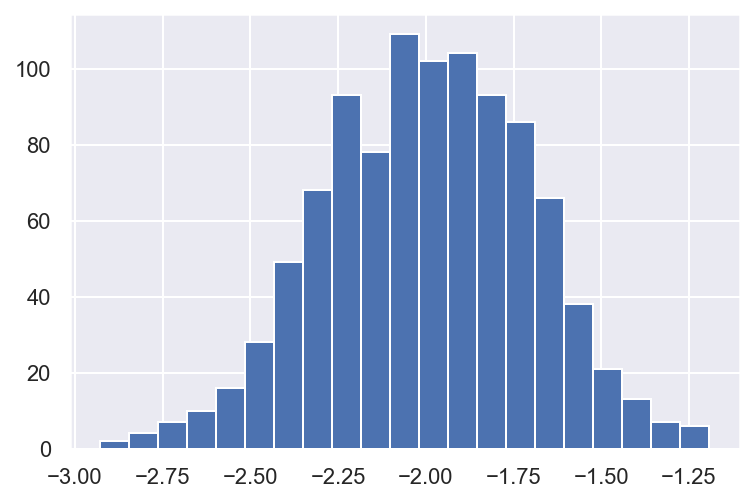

In [443]:
plt.hist(b_smp, bins='auto');

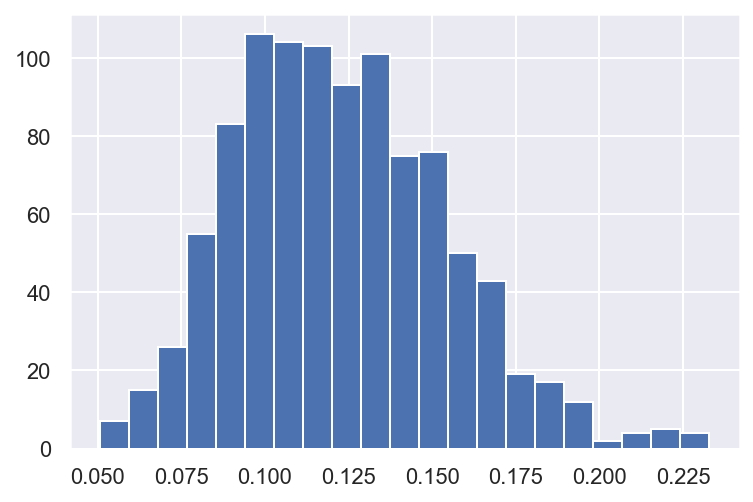

In [444]:
plt.hist(expit(b_smp), bins='auto');

In [445]:
print(len(y))

20000


In [446]:
print("sg_u", np.std(Zu, axis=0))
print("sg_w", np.std(Zw, axis=0))
print("mu", np.mean(Z, axis=0))

sg_u [0.54099092 0.2003145 ]
sg_w [0.75688435 0.33018865]
mu [-4.28114954 -2.06142483]


### Just one parameter over the two

In [447]:
%%time
eps = np.finfo(float).eps

old_sg_u = 1.
old_sg_w = 1.
old_mu = 0.

itr = 1

def optimize_Zu_Zw(x, y, sg_w, sg_u, mu):
    
    def opt(param):
        
        Zu = param[:n_u]
        Zw = param[n_u:]
        
        Z = Zu[u] + Zw[w]
        
        # a = np.exp(Z) 
        b = expit(Z)
        neg_rate = -a*x  *(1-b)**r                                             # p = np.exp(-rate*x)
        ll_y = np.sum(neg_rate*y+(1-y)*np.log(1 - np.exp(neg_rate)+eps))  # np.log(p**y*(1-p)**(1-y)+eps).sum()
        
        ll_zw = norm.logpdf(Zw, loc=mu/2, scale=sg_w).sum()
        ll_zu =  norm.logpdf(Zu, loc=mu/2, scale=sg_u).sum() 
        
        return - ll_y - ll_zw - ll_zu

    res = scipy.optimize.minimize(opt, 
                                  x0=np.zeros(n_u+n_w))
    
    return res.x[:n_u], res.x[n_u:]


while True:
    
    Zu, Zw = optimize_Zu_Zw(x=x, y=y, sg_w=old_sg_w, sg_u=old_sg_u, mu=old_mu)
    
    Z = Zu[u] + Zw[w]
    mu = np.mean(Z)
    sg_u = np.std(Zu)
    sg_w = np.std(Zw)
                                  
    print(itr, mu, sg_u, sg_w)
    if np.allclose([mu, sg_u, sg_w], [old_mu, old_sg_u, old_sg_w]):
        print("Converged!")
        break
    old_mu = mu
    old_sg_u = sg_u
    old_sg_w = sg_w
    itr += 1

1 -1.282909923610909 0.514471500603334 1.008738349963006
2 -1.4140689949748235 0.6486958184959905 0.8244015658130953
3 -2.0685916809589475 0.1955917202471861 0.32778055404560924
4 -2.071006961436686 0.19100654789785457 0.32202862656755715
5 -2.071100856198203 0.19077276792716047 0.3217920198087864
6 -2.071104965319864 0.1907605111023735 0.32178189988021266
7 -2.0711051396077456 0.19075987407521205 0.32178144061169606
Converged!
CPU times: user 1min 11s, sys: 1.14 s, total: 1min 12s
Wall time: 1min 28s


### Both parameters at same time

In [448]:
%%time
eps = np.finfo(float).eps

old_sg_u = np.ones(2) - np.inf
old_sg_w = np.ones(2) - np.inf
old_mu = np.zeros(2)

itr = 1

def optimize_Zu_Zw_FIRST(x, y):

    def opt(param):

        Zu = param[:n_u*2].reshape((n_u, 2))
        Zw = param[n_u*2:].reshape((n_w, 2))

        Z = Zu[u] + Zw[w]

        a = np.exp(Z[:, 0]) 
        b = expit(Z[:, 1])
        neg_rate = -a*x  *(1-b)**r                                             
        ll_y = np.sum(neg_rate*y+(1-y)*np.log(1 - np.exp(neg_rate)+eps))       

        return - ll_y

    res = scipy.optimize.minimize(opt, 
                                  x0=np.zeros(n_u*2+n_w*2))

    return res.x[:n_u*2].reshape((n_u, 2)), res.x[n_u*2:].reshape((n_w, 2))

def optimize_Zu_Zw(x, y, sg_w, sg_u, mu):
    
    def opt(param):
        
        Zu = param[:n_u*2].reshape((n_u, 2))
        Zw = param[n_u*2:].reshape((n_w, 2))
        
        Z = Zu[u] + Zw[w]
        
        a = np.exp(Z[:, 0]) 
        b = expit(Z[:, 1])
        neg_rate = -a*x  *(1-b)**r                                             # p = np.exp(-rate*x)
        ll_y = np.sum(neg_rate*y+(1-y)*np.log(1 - np.exp(neg_rate)+eps))       # np.log(p**y*(1-p)**(1-y)+eps).sum()
        
        ll_zw = norm.logpdf(Zw, loc=mu/2, scale=sg_w).sum()
        ll_zu =  norm.logpdf(Zu, loc=mu/2, scale=sg_u).sum() 
        
        return - ll_y - ll_zw - ll_zu

    res = scipy.optimize.minimize(opt, 
                                  x0=np.zeros(n_u*2+n_w*2))
    
    return res.x[:n_u*2].reshape((n_u, 2)), res.x[n_u*2:].reshape((n_w, 2))


while True:
    
    if itr == 1:
        Zu, Zw = optimize_Zu_Zw_FIRST(x=x, y=y)
    else:
        Zu, Zw = optimize_Zu_Zw(x=x, y=y, sg_w=old_sg_w, sg_u=old_sg_u, mu=old_mu)
    
    mu = np.mean(Zu[u] + Zw[w], axis=0)
    sg_u = np.std(Zu, axis=0)
    sg_w = np.std(Zw, axis=0)
                                  
    print(itr, mu, sg_u, sg_w)
    if np.allclose([mu, sg_u, sg_w], [old_mu, old_sg_u, old_sg_w]):
        print("Converged!")
        break
    old_mu = mu
    old_sg_u = sg_u
    old_sg_w = sg_w
    itr += 1

1 [-4.24278741 -2.05694662] [0.58893745 0.1970424 ] [0.80205766 0.31617933]
2 [-2.50572476 -1.46702302] [1.57634058 0.64156748] [2.89144327 0.60018144]
3 [-4.23524855 -2.05335838] [0.58612194 0.1951994 ] [0.80547475 0.31202108]
4 [-2.04402308 -1.37752087] [1.31061334 0.49579481] [2.61904587 0.60410462]
5 [-4.23097388 -2.05120617] [0.58487441 0.19415335] [0.80612138 0.31244508]
6 [-1.57757453 -0.86899205] [1.06105364 0.39776217] [1.18722927 0.3199334 ]
7 [-4.1933331  -2.03344612] [0.58666256 0.19245421] [0.81170743 0.30524495]
8 [-4.25412396 -2.06071922] [0.5633401  0.18151713] [0.78403044 0.30181495]
9 [-4.25777386 -2.06227075] [0.56126726 0.17982232] [0.78163746 0.30147753]
10 [-4.25803074 -2.06237651] [0.56112483 0.17952268] [0.78148326 0.30143423]
11 [-4.25804954 -2.06238472] [0.56112562 0.17946705] [0.78148654 0.30142501]
12 [-4.25805045 -2.06238532] [0.56112896 0.17945639] [0.78149079 0.30142268]
13 [-4.25805058 -2.06238539] [0.56112977 0.17945439] [0.78149151 0.30142217]
14 [-4.2